In [44]:
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import random
import warnings
from copy import deepcopy

from data_utils import (
    PBM_SIM_PATHS,
    PBM_FEATURES,
    PBM_TARGET,
    BATTERY_FEATURES,
    BATTERY_TARGET,
    load_battery_data,
    make_sequences
)
from models import train_pbm_surrogate_for_PI_RNN, MultiStepPIRNN, BaselineMultiStepRNN, GPRBaseline

warnings.filterwarnings('ignore')
# —————————————————————————————
# 0. Styling & reproducibility
# —————————————————————————————
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size']   = 20

seed = 40
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

# —————————————————————————————
# 1. Train PBM surrogate
# —————————————————————————————
rf_model, scaler_sim = train_pbm_surrogate_for_PI_RNN(
    PBM_SIM_PATHS,
    PBM_FEATURES,
    PBM_TARGET,
    seed=seed
)

# —————————————————————————————
# 2. Load & preprocess battery data
# —————————————————————————————
X_train_s, y_train, X_val_s, y_val, X_test_s, y_test, scaler, test_df, tv = \
    load_battery_data(seed=seed)

print("Training: ", tv['Unique_Cell_ID'].unique())
print("Testing: ", test_df['Unique_Cell_ID'].unique())

# Scenario‐3 constants
h3 = 20
input_size  = len(BATTERY_FEATURES) + 1
hidden_size = 50

# —————————————————————————————
# 3. Load pretrained Scenario‐3 models
# —————————————————————————————
pi3 = MultiStepPIRNN(input_size, hidden_size, rf_model)
pi3.load_state_dict(torch.load('saved_models/pi3_scenario3.pth'))
pi3.eval()

b3 = BaselineMultiStepRNN(input_size, hidden_size)
b3.load_state_dict(torch.load('saved_models/b3_scenario3.pth'))
b3.eval()

def parse_cell_list(cell_string):
    """Parse comma-separated cell list into (group, cell) tuples."""
    cells = []
    for cell_id in cell_string.split(','):
        cell_id = cell_id.strip()
        if '-' in cell_id:
            group, cell = cell_id.split('-')
            cells.append((group, cell))
        else:
            print(f"Warning: Invalid cell format '{cell_id}'. Expected format: 'G3-C1'")
    return cells

def trajectory_forecast_single_cell(
    group: str,
    cell:  str,
    fine_tune: bool = False,
    fine_tune_epochs: int = 20,
    return_predictions: bool = False
):
    """Forecast trajectory for a single cell (original function logic)."""
    # select cell data
    df = (
        test_df
        .loc[lambda d: (d['Group']==group) & (d['Cell']==cell)]
        .sort_values('RPT Number')
        .reset_index(drop=True)
    )
    df[BATTERY_FEATURES] = df[BATTERY_FEATURES].fillna(0)

    # --- fill any single‐gap RPT numbers by neighbor‐averaging ---
    rpts = df['RPT Number']
    min_rpt, max_rpt = rpts.min(), rpts.max()

    full_set = set(range(min_rpt, max_rpt + 1))
    missing_rpts = sorted(full_set - set(rpts))

    # for each missing rpt, if both neighbors exist, interpolate
    to_add = []
    for m in missing_rpts:
        prev_r, next_r = m - 1, m + 1
        if prev_r in rpts.values and next_r in rpts.values:
            v_prev = df.loc[df['RPT Number']==prev_r, BATTERY_TARGET].iloc[0]
            v_next = df.loc[df['RPT Number']==next_r, BATTERY_TARGET].iloc[0]
            f_prev = df.loc[df['RPT Number']==prev_r, BATTERY_FEATURES].iloc[0]
            f_next = df.loc[df['RPT Number']==next_r, BATTERY_FEATURES].iloc[0]
            to_add.append({
                'RPT Number': m,
                **{BATTERY_TARGET: (v_prev+v_next)/2},
                **{feat: (f_prev[feat]+f_next[feat])/2 for feat in BATTERY_FEATURES}
            })

    # append & re‐sort only if there's something to add
    if to_add:
        df = pd.concat([df, pd.DataFrame(to_add)], ignore_index=True)
        df = df.sort_values('RPT Number').reset_index(drop=True)

    print(f"Cell {group}-{cell}: Total de linhas: {len(df)}, Máximo RPT Number: {df['RPT Number'].max()}")

    # available and future splits for scenario 3 forecasting
    avail = df[df['RPT Number'] <= h3]
    fut   = df[df['RPT Number'] >  h3]
    fw    = fut.iloc[:h3]           # forecast window size = h3
    n     = len(fw)

    model = pi3
    baseline = b3

    # prepare future-window tensor for RNNs
    Xf = scaler.transform(fw[BATTERY_FEATURES].values)
    Xt = torch.tensor(Xf, dtype=torch.float32).unsqueeze(0)
    St = torch.tensor([[avail[BATTERY_TARGET].iloc[-1]]], dtype=torch.float32)

    with torch.no_grad():
        bb = baseline(Xt, St, forecast_steps=n).cpu().numpy().squeeze(0)
        pp = model   (Xt, St, forecast_steps=n).cpu().numpy().squeeze(0)

    # return raw arrays if requested
    if return_predictions:
        return {
            'group': group,
            'cell': cell,
            'available_idx': avail.index.values,
            'forecast_idx':  fw.index.values,
            'true_values':   fw[BATTERY_TARGET].values,
            'baseline_rnn':   bb,
            'pi_rnn':         pp
        }
    
    return df, avail, fut, fw, bb, pp

def trajectory_forecast_multi_cell(
    cells_list: list,
    fine_tune: bool = False,
    fine_tune_epochs: int = 20,
    return_predictions: bool = False
):
    """Forecast trajectories for multiple cells."""
    
    if return_predictions:
        results = []
        for group, cell in cells_list:
            try:
                result = trajectory_forecast_single_cell(
                    group, cell, fine_tune, fine_tune_epochs, return_predictions=True
                )
                results.append(result)
            except Exception as e:
                print(f"Error processing cell {group}-{cell}: {e}")
        return results
    
    # —————————————————————————————
    # 5. Multi-cell Plotting 
    # —————————————————————————————
    forecast_rpts     = [1, 15, 20]
    forecast_horizons = [29, 29, 18]
    phases            = ["(primeiro)","(segundo)","(terceiro)"]
    
    n_cells = len(cells_list)
    n_phases = len(forecast_rpts)
    
    # Create figure with subplots: rows = cells, cols = phases
    fig, axes = plt.subplots(n_cells, n_phases, figsize=(6*n_phases, 6*n_cells), dpi=100)
    
    # Handle case where there's only one cell (axes won't be 2D)
    if n_cells == 1:
        axes = axes.reshape(1, -1)
    elif n_phases == 1:
        axes = axes.reshape(-1, 1)
    
    for cell_idx, (group, cell) in enumerate(cells_list):
        try:
            # Get data for this cell
            df, avail, fut, fw, bb, pp = trajectory_forecast_single_cell(
                group, cell, fine_tune, fine_tune_epochs, return_predictions=False
            )
            
            # Plot each phase for this cell
            for phase_idx, (rpt, horizon, phase) in enumerate(zip(forecast_rpts, forecast_horizons, phases)):
                ava  = df[df['RPT Number'] <= rpt]
                fut_i= df[df['RPT Number'] >  rpt]
                fw_i = fut_i.iloc[:horizon]
                n_i  = len(fw_i)
                
                ax = axes[cell_idx, phase_idx] if n_cells > 1 else axes[0, phase_idx]
                ax.axvline(x=rpt, color='black', linestyle='--', linewidth=1)

                # available
                ax.plot(ava.index+1, ava[BATTERY_TARGET],
                        'ko-', markersize=8, linewidth=1.5, label='Data Available')
                
                # connector
                if not ava.empty and not fut_i.empty:
                    idx0, idx1 = ava.index[-1], fut_i.index[0]
                    v0, v1     = ava[BATTERY_TARGET].iloc[-1], fut_i[BATTERY_TARGET].iloc[0]
                    ax.plot([idx0+1, idx1+1], [v0, v1], 'k-', linewidth=2)

                # true future
                ax.plot(fut_i.index +1, fut_i[BATTERY_TARGET],
                        'ko-', markersize=8, linewidth=1.5,
                        markerfacecolor='white', label='True Capacity')

                # RNNs
                if n_i > 0:
                    raw = fw_i[BATTERY_FEATURES].values
                    Xf_i  = scaler.transform(raw)
                    Xt_i  = torch.tensor(Xf_i, dtype=torch.float32).unsqueeze(0)
                    St_i  = torch.tensor([[ava[BATTERY_TARGET].iloc[-1]]], dtype=torch.float32)
                    
                    print(f"\n*** {group}-{cell} Phase {phase_idx+1} ***")
                    
                    # Format the features with their names
                    
                    features_original = fw_i[BATTERY_FEATURES].iloc[0].values
                    
                    print("Features (original):")
                    for i, (name, value) in enumerate(zip(BATTERY_FEATURES, features_original)):
                        print(f"  {name:<40}: {value:>12.6f}")
                    
                    print(f"\nInitial {BATTERY_TARGET:<40}: {ava[BATTERY_TARGET].iloc[-1]:>12.6f}")
                    print()
                    
                    with torch.no_grad():
                        bb_i = b3(Xt_i, St_i, forecast_steps=n_i).cpu().numpy().squeeze(0)
                        pp_i = pi3(Xt_i, St_i, forecast_steps=n_i).cpu().numpy().squeeze(0)
                    rpt = df['RPT Number'].values 
                  
                    
                    
                    ax.plot(fw_i.index+1, pp_i,
                            'd', color='crimson', markersize=6,
                            linestyle='-', linewidth=0.5, label='PI-RNN')


                
                ax.set_title(f"{group}-{cell} {phase}", fontsize=18)
                ax.set_xlabel('RPT Number (-)', fontsize=14)
                ax.set_xticks(np.arange(0, 35, 5))
                ax.set_ylabel('Capacity (Ah)', fontsize=14)
                ax.set_yticks(np.arange(0.4, 1.6, 0.2))
                ax.set_xlim(-2, 35)
                ax.set_ylim(0.4, 1.4)
                ax.tick_params(labelsize=12)
                
                # Only show legend on first subplot to avoid clutter
                if cell_idx == 0 and phase_idx == 0:
                    ax.legend(loc='upper right', fontsize=10)
                    
        except Exception as e:
            print(f"Error plotting cell {group}-{cell}: {e}")
            # Fill row with empty plots if cell fails
            for phase_idx in range(n_phases):
                ax = axes[cell_idx, phase_idx] if n_cells > 1 else axes[0, phase_idx]
                ax.set_title(f"{group}-{cell} (ERROR)", fontsize=18)
                ax.text(0.5, 0.5, f"Error: {str(e)}", transform=ax.transAxes, 
                       ha='center', va='center', fontsize=12)
   
    plt.tight_layout()
    plt.show()

def trajectory_forecast(
    group: str = None,
    cell: str = None,
    cells_list: list = None,
    fine_tune: bool = False,
    fine_tune_epochs: int = 20,
    return_predictions: bool = False
):
    """Main function that handles both single and multi-cell forecasting."""
    
    if cells_list is not None:
        # Multi-cell mode
        return trajectory_forecast_multi_cell(
            cells_list, fine_tune, fine_tune_epochs, return_predictions
        )
    elif group is not None and cell is not None:
        # Single cell mode (legacy)
        return trajectory_forecast_single_cell(
            group, cell, fine_tune, fine_tune_epochs, return_predictions
        )
    else:
        raise ValueError("Either provide cells_list or both group and cell parameters")

def run_forecast(cells=None, group='G3', cell='C1', fine_tune=False, epochs=20, return_predictions=False):
    """Function to replace the main block for Jupyter notebook usage."""
    
    if cells:
        # Multi-cell mode
        cells_list = parse_cell_list(cells)
        print(f"Processing {len(cells_list)} cells: {cells_list}")
        
        out = trajectory_forecast(
            cells_list=cells_list,
            fine_tune=fine_tune,
            fine_tune_epochs=epochs,
            return_predictions=return_predictions
        )
    else:
        # Single cell mode (legacy)
        print(f"Processing single cell: {group}-{cell}")
        
        out = trajectory_forecast(
            group=group,
            cell=cell,
            fine_tune=fine_tune,
            fine_tune_epochs=epochs,
            return_predictions=return_predictions
        )
    
    if return_predictions:
        print(out)
    
    return out

Training:  ['G1-C1' 'G1-C2' 'G1-C3' 'G2-C1' 'G2-C2' 'G2-C3' 'G4-C1' 'G4-C2' 'G4-C3'
 'G11-C1' 'G11-C2' 'G11-C3' 'G14-C1' 'G14-C2' 'G14-C3' 'G16-C1' 'G16-C2'
 'G16-C3' 'G17-C1' 'G17-C2' 'G17-C3' 'G18-C1' 'G18-C2' 'G18-C3']
Testing:  ['G3-C1' 'G3-C2' 'G3-C3' 'G5-C1' 'G5-C2' 'G5-C3' 'G6-C1' 'G6-C2' 'G6-C3'
 'G7-C1' 'G7-C2' 'G7-C3' 'G8-C1' 'G8-C2' 'G8-C3' 'G12-C1' 'G12-C2'
 'G12-C3' 'G13-C1' 'G13-C2' 'G13-C3' 'G15-C1' 'G15-C2' 'G15-C3']


Processing 24 cells: [('G3', 'C1'), ('G3', 'C2'), ('G3', 'C3'), ('G5', 'C1'), ('G5', 'C2'), ('G5', 'C3'), ('G6', 'C1'), ('G6', 'C2'), ('G6', 'C3'), ('G7', 'C1'), ('G7', 'C2'), ('G7', 'C3'), ('G8', 'C1'), ('G8', 'C2'), ('G8', 'C3'), ('G12', 'C1'), ('G12', 'C2'), ('G12', 'C3'), ('G13', 'C1'), ('G13', 'C2'), ('G13', 'C3'), ('G15', 'C1'), ('G15', 'C2'), ('G15', 'C3')]
Cell G3-C1: Total de linhas: 33, Máximo RPT Number: 33.0

*** G3-C1 Phase 1 ***
Features (original):
  Ampere-Hour Throughput (Ah)             :   456.861098
  Total Absolute Time From Start (h)      :   241.713889
  Total Time Elapsed (h)                  :   120.868611
  Time Below 3A (h)                       :    22.465556
  Time Between 3A and 4A (h)              :     1.066944
  Time Above 4A (h)                       :    97.336111
  RPT Number                              :     2.000000

Initial Capacity                                :     1.215821


*** G3-C1 Phase 2 ***
Features (original):
  Ampere-Hour Throughput

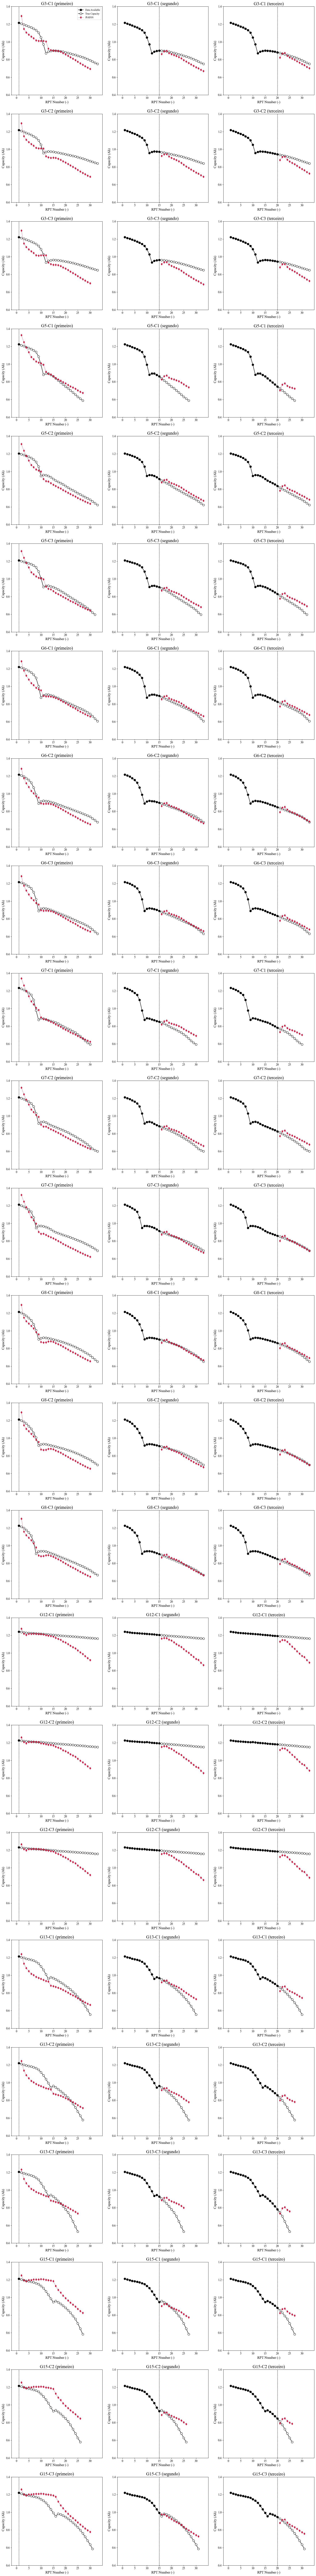

In [47]:
# All test cells from your output
all_test_cells = "G3-C1,G3-C2,G3-C3,G5-C1,G5-C2,G5-C3,G6-C1,G6-C2,G6-C3,G7-C1,G7-C2,G7-C3,G8-C1,G8-C2,G8-C3,G12-C1,G12-C2,G12-C3,G13-C1,G13-C2,G13-C3,G15-C1,G15-C2,G15-C3"

# Run forecast with all cells
result = run_forecast(cells=all_test_cells)

# If you want to get the predictions as well
# result = run_forecast(cells=all_test_cells, return_predictions=True)